In [1]:
#!pip install tensorflow-hub

import cv2
import numpy as np

import tensorflow_hub

import openvino as ov

In [2]:

detector = tensorflow_hub.load("https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/TensorFlow2/variations/ssd-mobilenet-v2/versions/1")

In [3]:
import openvino as ov

ov_model = ov.convert_model(detector)
ov_model

<Model: 'TensorFlow_Frontend_IR'
inputs[
<ConstOutput: names[input_tensor] shape[1,?,?,3] type: u8>
]
outputs[
<ConstOutput: names[detection_anchor_indices] shape[1,?] type: f32>,
<ConstOutput: names[detection_boxes] shape[1,?,..8] type: f32>,
<ConstOutput: names[detection_classes] shape[1,?] type: f32>,
<ConstOutput: names[detection_multiclass_scores] shape[1,?,..182] type: f32>,
<ConstOutput: names[detection_scores] shape[1,?] type: f32>,
<ConstOutput: names[num_detections] shape[1] type: f32>,
<ConstOutput: names[raw_detection_boxes] shape[1,1917,4] type: f32>,
<ConstOutput: names[raw_detection_scores] shape[1,1917,91] type: f32>
]>

In [4]:
compiled_model = ov.compile_model(ov_model, device_name='CPU')
compiled_model

<CompiledModel:
inputs[
<ConstOutput: names[input_tensor] shape[1,?,?,3] type: u8>
]
outputs[
<ConstOutput: names[detection_anchor_indices] shape[1,?] type: f32>,
<ConstOutput: names[detection_boxes] shape[1,?,..8] type: f32>,
<ConstOutput: names[detection_classes] shape[1,?] type: f32>,
<ConstOutput: names[detection_multiclass_scores] shape[1,?,..182] type: f32>,
<ConstOutput: names[detection_scores] shape[1,?] type: f32>,
<ConstOutput: names[num_detections] shape[1] type: f32>,
<ConstOutput: names[raw_detection_boxes] shape[1,1917,4] type: f32>,
<ConstOutput: names[raw_detection_scores] shape[1,1917,91] type: f32>
]>

In [13]:
img = cv2.imread('cars.jpg')
print(img.shape)
img = cv2.resize(img, (300, 300))
reshaped_img = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)   # BGR -> RGB
img = np.expand_dims(img, axis=0)                             # HWC -> NHWC (h,w,c) -> (1,h,w,c)
print(img.shape)

(3456, 5184, 3)
(1, 300, 300, 3)


In [14]:
res = compiled_model.infer_new_request(img)

In [15]:
coco_class_label = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
                    'fire hydrant', 'stop sign','parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
                    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
                    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 
                    'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 
                    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 
                    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
                    'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

coco_class_label = [ '_background_' ] + coco_class_label

pascal_voc_class_label = ['Person', 'Car', 'Bicycle', 'Bus', 'Motorbike', 'Train', 'Aeroplane', 'Chair', 'Bottle', 'Dining Table', 'Potted Plant', 
                          'TV/Monitor', 'Sofa', 'Bird', 'Cat', 'Cow', 'Dog', 'Horse', 'Sheep' ]

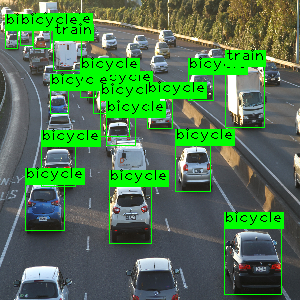

In [17]:
img_w, img_h, _ = reshaped_img.shape
out_img = reshaped_img.copy()

num_detections = int(res['num_detections'][0])
for (rel_y0,rel_x0,rel_y1,rel_x1), class_id, score in zip(res['detection_boxes'][0], res['detection_classes'][0], res['detection_scores'][0]):
    if score > 0.65:
        x0 = int(img_w * rel_x0)
        y0 = int(img_h * rel_y0)
        x1 = int(img_w * rel_x1)
        y1 = int(img_h * rel_y1)
        # Draw BBox
        cv2.rectangle(out_img, (x0, y0), (x1, y1), (0,255,0), 1)
        # Draw class label
        text = coco_class_label[int(class_id)]
        (w, h), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, fontScale=1, thickness=1)
        cv2.rectangle(out_img, (x0, y0), (x0 + w, y0 - h - baseline), color=(0,255,0), thickness=-1)
        cv2.putText(out_img, text, (x0, y0 - baseline), cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(0,0,0), thickness=1)

from PIL import Image
from IPython.display import display
out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
pil_img = Image.fromarray(out_img)
display(pil_img)
